In [1181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

import folium
from folium.plugins import HeatMap
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import plotly.express as px

from scipy.interpolate import griddata
from numpy import linspace

In [1120]:
matplotlib.rc_file_defaults()

In [1185]:
incident_report = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
reference_codes = pd.read_csv('Reference__Police_Department_Incident_Code_Crosswalk_with_ucr.csv')

# rename reference code column to merge 

reference_codes.rename(columns = {'INC_CODE':'Incident Code'}, inplace = True)

# merge dataframes; 460432 rows and 39 columns

incident_report = incident_report.merge(reference_codes, on = 'Incident Code', how = 'left', indicator = True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', False)

In [926]:
# incident_report.info()

In [927]:
incident_report['_merge'].value_counts(dropna = False)

both          460073
left_only        359
right_only         0
Name: _merge, dtype: int64

# Pre-processing

In [933]:
# dropping columns

incident_report.drop(columns = ['Incident Datetime','Supervisor District', 'Current Supervisor Districts'], inplace = True)

In [934]:
# function to filter out unwanted categories
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == False]

In [935]:
# updated has 246439 rows and 36 columns
incident_report = filter_rows_by_values(incident_report, 'Incident Category', ['Case Closure','Civil Sidewalks','Courtesy Report',
                              'Fire Report','Lost Property','Missing Person','Non-Criminal',
                              'Other','Recovered Vehicle','Suicide','Suspicious','Suspicious Occ',
                              'Traffic Collision','Vehicle Impounded','Vehicle Misplaced','Warrant', 'Liquor Laws', 'Gambling',
                            'Malicious Mischief', 'Other Miscellaneous','Fraud', 'Disorderly Conduct', 'Miscellaneous Investigation',
                                'Other Offenses', 'Traffic Violation Arrest', 'Weapons Offense', 'Forgery and Counterfeiting', 'Weapons Carrying Etc',
                                'Stolen Property', 'Prostitution', 'Embezzlement', 'Vandalism', 'Sex Offense'])

In [936]:
# convert to datetime ; data starts at 2018-01-01 and ends at 2021-07-20

incident_report['Incident Date'] = pd.to_datetime(incident_report['Incident Date'])

In [937]:
# omitting entries later than June 30, 2021 because latest date is 07-20-2021
# 243098 rows and 37 columns

incident_report = incident_report[incident_report['Incident Date'] <= '2021-06-30']

In [938]:
# extracting months variable

incident_report['Months']=incident_report['Incident Date'].dt.month

In [939]:
# changing to month digits to full month names 

months_dict = {1:'January', 2:'February', 3:'March', 4:'April',5:'May', 6:'June', 
           7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

incident_report['Months'].replace(months_dict, inplace = True)

In [940]:
# dropping duplicates and keeping only the highest crime category based on UCR hierarchy 
# 228879 rows and 37 columns

incident_report = incident_report.sort_values('UCR_part_1_code').drop_duplicates('Incident ID', keep = 'first')

In [941]:
# variable to see whether there is a CAD number or not
# 232017 rows and 38 columns

incident_report['Binary CAD'] = incident_report['CAD Number'].notnull()*1

In [942]:
# adding geometric variable

geometry = [Point(xy) for xy in zip(incident_report['Longitude'], incident_report['Latitude'])]
incident_report = gpd.GeoDataFrame(incident_report, geometry = geometry)

# Total Incidents

In [1022]:
# graphing totals over time

def total_graph(df, title):
    monthly_counts = (
    df[["Incident Year", "Months", "Incident ID"]]
    .groupby(["Incident Year", "Months"])
    .agg(incident_count=("Incident ID", "count"))
    .reset_index()
    )
    monthly_counts["ym"] = pd.to_datetime(
    monthly_counts["Months"]
    + " "
    + "01"
    + ", "
    + monthly_counts["Incident Year"].astype(str),
    format="%B %d, %Y",
    )
    monthly_counts = monthly_counts.sort_values("ym")
    monthly_counts = monthly_counts.loc[(monthly_counts["ym"] > "2019-02-01")]
    ax = sns.lineplot(data=monthly_counts, x="ym", y="incident_count")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.axvline(pd.to_datetime("2020-03-01"), color = 'red', linewidth = .8, linestyle = '--')
    plt.xticks(rotation=90)
    ax.set_title(title)
    plt.xlabel('')
    plt.ylabel('Incident Count')
    plt.show()

In [1023]:
# function to filter wanted categories

def filter_inrows_by_values(df, col, values):
    return df[df[col].isin(values) == True]

In [1080]:
# total_incidents1 - with 8 UCR categories - reduces the dataset to 195028 rows

total_incidents1 = filter_inrows_by_values(incident_report, 'UCR_part_1', ['aggravated assault', 'rape',
                                                                        'homicide ', 'robbery', 'burglary ', 
                                                                        'arson', 'larceny theft','motor vehicle theft'])
total_incidents = pd.pivot_table(total_incidents1, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
total_incidents = total_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_incidents 

Incident Year,2018,2019,2020,2021
Months,,,,
January,5860.0,4889.0,5522.0,3461.0
February,4831.0,4482.0,4799.0,3690.0
March,5075.0,4811.0,3791.0,3706.0
April,5086.0,4669.0,3214.0,3808.0
May,5379.0,5076.0,3167.0,4834.0
June,5424.0,5159.0,2808.0,4702.0
July,6189.0,5795.0,3122.0,NaN
August,6094.0,6075.0,3047.0,NaN
September,5461.0,5629.0,2588.0,NaN


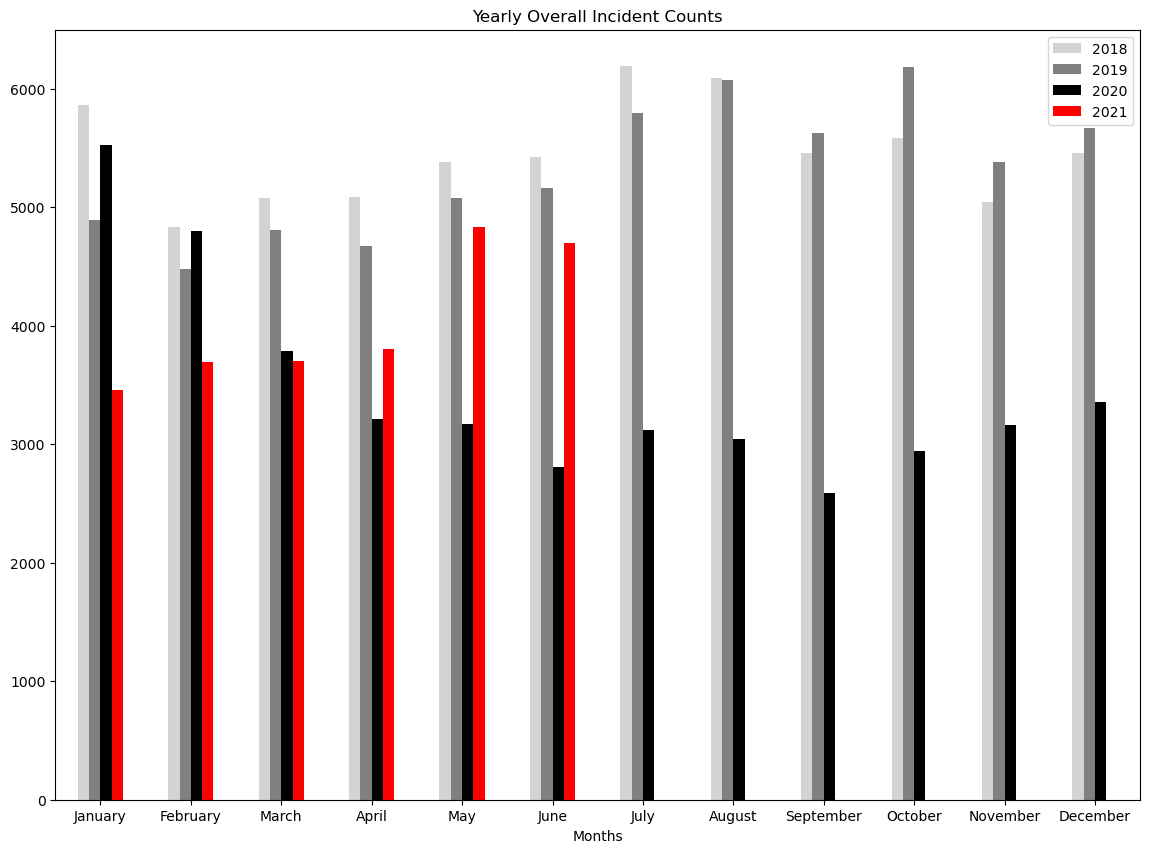

In [1106]:
total_incidents.plot(kind = 'bar', figsize = (14,10), color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Incident Counts')
plt.legend(loc = 'best');

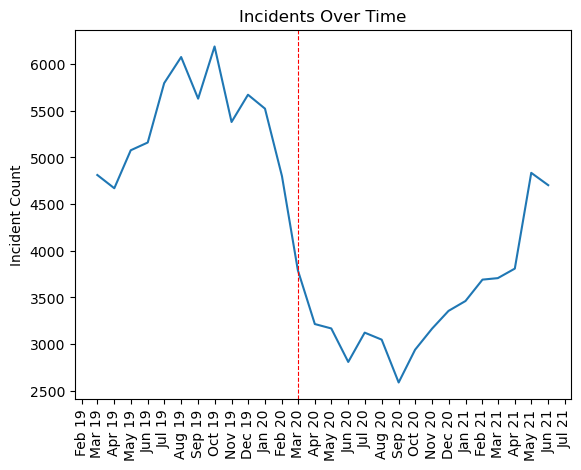

In [1107]:
total_graph(total_incidents1, 'Incidents Over Time')

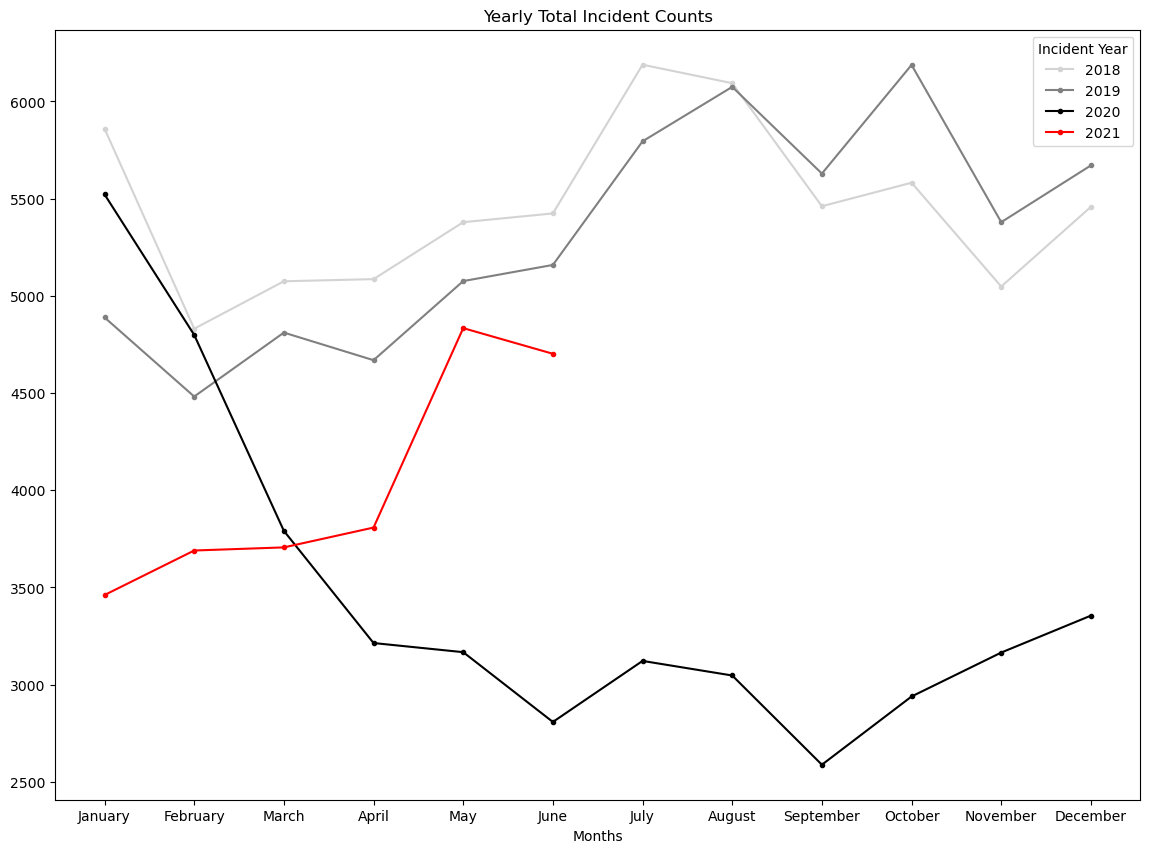

In [1108]:
line = total_incidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
line.set_xticks(np.arange(0,12))
line.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
line.set_title('Yearly Total Incident Counts');

# Violent Incidents 

In [1028]:
# violent crime visualization 
# (19061, 39) using UCR categories

violentincidents = filter_inrows_by_values(incident_report, 'UCR_part_1', ['aggravated assault', 'rape',
                                                                           'homicide ', 'robbery'])

In [1078]:
violent_incidents = pd.pivot_table(violentincidents, index = 'Months', columns = 'Incident Year', values = 'UCR_part_1', aggfunc = 'size')
total_violentincidents = violent_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_violentincidents

Incident Year,2018,2019,2020,2021
Months,,,,
January,492.0,460.0,461.0,353.0
February,536.0,373.0,518.0,435.0
March,507.0,494.0,444.0,375.0
April,471.0,462.0,319.0,385.0
May,548.0,508.0,305.0,439.0
June,581.0,498.0,274.0,439.0
July,579.0,503.0,298.0,NaN
August,545.0,590.0,287.0,NaN
September,497.0,504.0,302.0,NaN


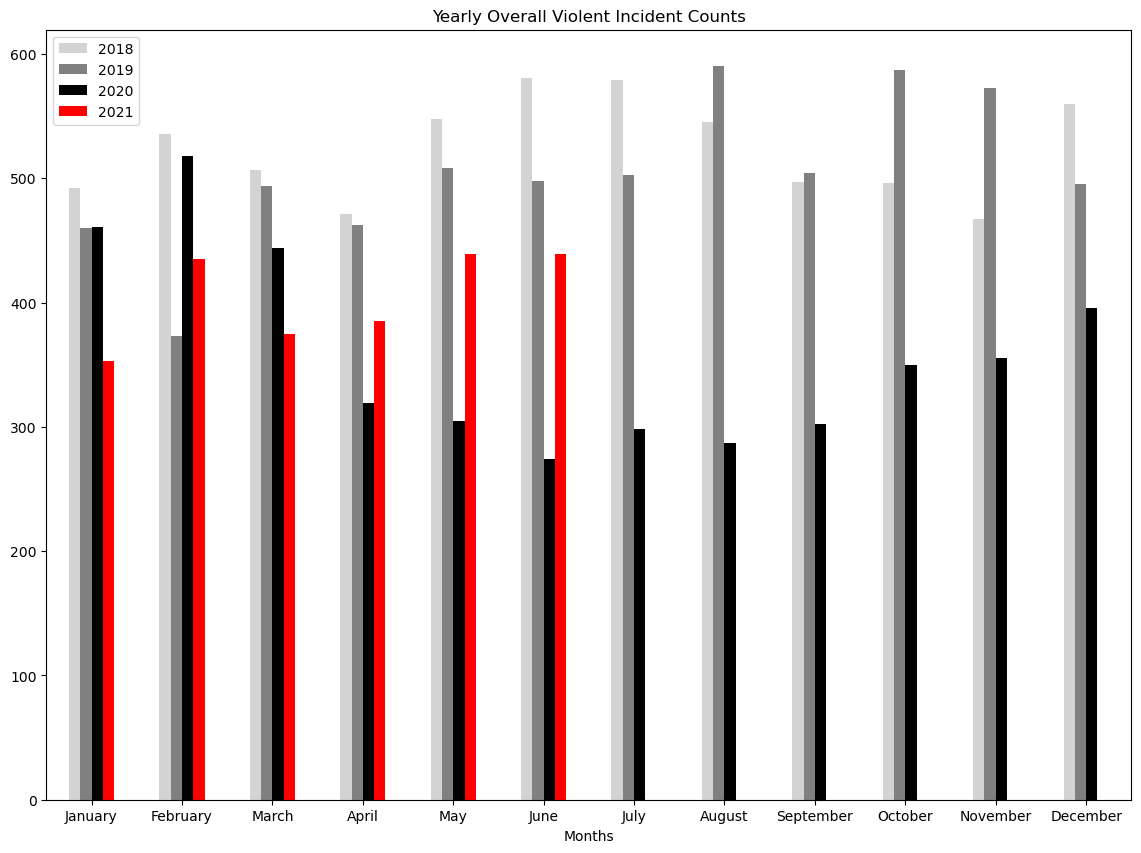

In [1104]:
total_violentincidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Violent Incident Counts')
plt.legend(loc = 'best');

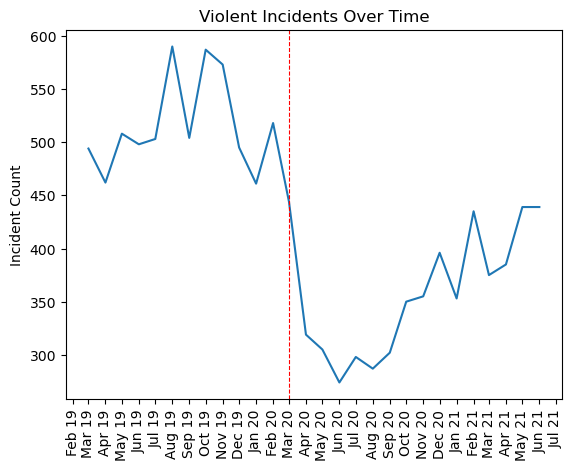

In [963]:
total_graph(violentincidents, 'Violent Incidents Over Time')

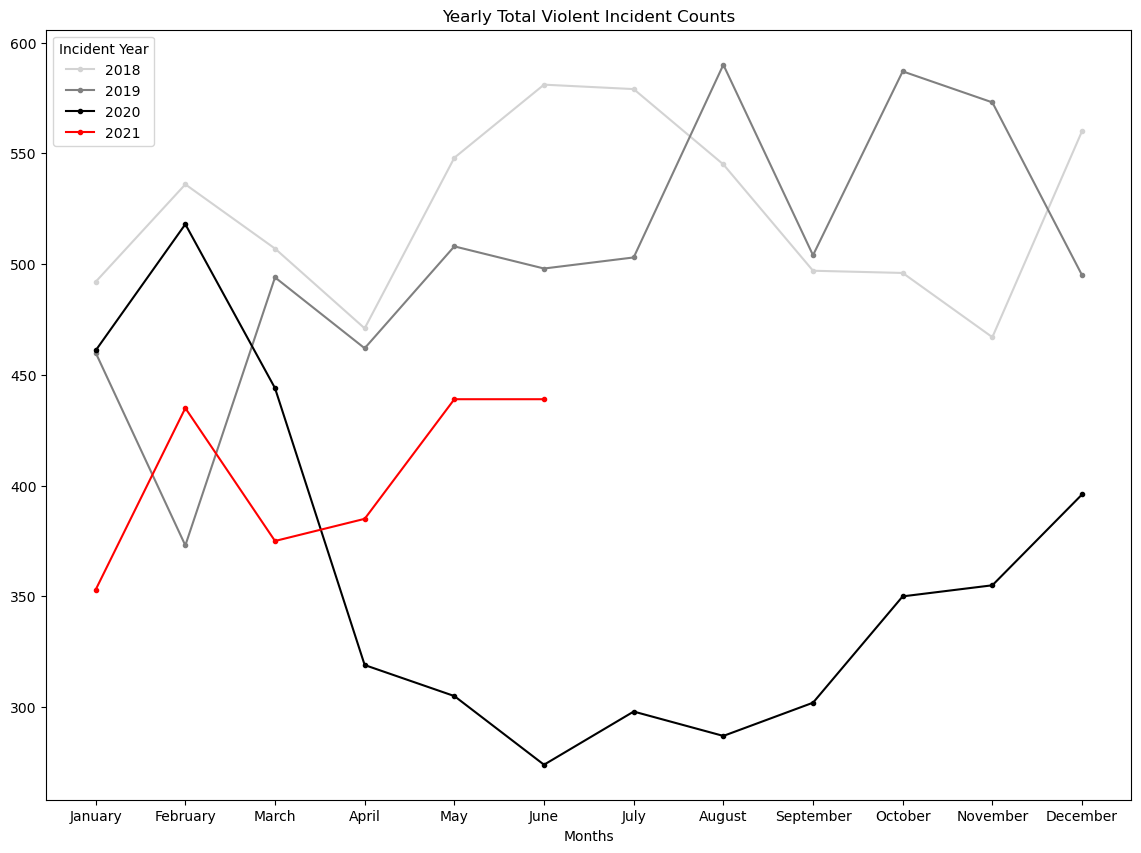

In [1103]:
violentline = total_violentincidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
violentline.set_xticks(np.arange(0,12))
violentline.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
violentline.set_title('Yearly Total Violent Incident Counts');

In [1559]:
# incidents (month/year)

def incident_agg(df):
    table = pd.pivot_table(
    df, 
    index = ['UCR_part_1', 'Months'], 
    columns = ['Incident Year'], 
    values = 'Incident ID', 
    aggfunc = 'size').reindex(
    ['January', 'February', 'March', 'April', 'May', 
     'June', 'July', 'August', 'September', 'October', 
     'November', 'December'], 
    axis=0, level=1)
    return table

In [1560]:
# graph incidents

def incident_graph(df, itype, title):
        df = df[df['UCR_part_1'] == itype]
        table = pd.pivot_table(
            df,
            index = 'Months', 
            columns = 'Incident Year', 
            values = 'Incident ID', 
            aggfunc = 'size').reindex(
            index = ['January', 'February', 'March', 'April', 'May', 
                    'June', 'July', 'August', 'September', 'October', 'November', 
                    'December']) 
        plot = table.plot(
            kind = 'line', 
            figsize = (14,10),
            color = ['lightgray', 'gray', 'black', 'red'], 
            marker = '.',
            rot = 0)
        plot.set_xticks(np.arange(0,12))
        plot.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
        plot.set_title(title)

In [1561]:
incident_agg(violentincidents)

Incident Year                  2018   2019   2020   2021
UCR_part_1         Months                               
aggravated assault January    212.0  164.0  163.0  175.0
                   February   222.0  140.0  185.0  175.0
                   March      217.0  240.0  184.0  178.0
                   April      228.0  203.0  151.0  207.0
                   May        239.0  249.0  164.0  240.0
                   June       256.0  221.0  133.0  226.0
                   July       227.0  240.0  139.0    NaN
                   August     239.0  270.0  134.0    NaN
                   September  191.0  215.0  169.0    NaN
                   October    208.0  228.0  205.0    NaN
                   November   193.0  201.0  178.0    NaN
                   December   198.0  206.0  179.0    NaN
...                             ...    ...    ...    ...
robbery            January    277.0  288.0  294.0  176.0
                   February   311.0  230.0  329.0  257.0
                   March      287.0  251.0  259.0  193.0
                   April      239.0  257.0  168.0  177.0
                   May        306.0  254.0  138.0  198.0
                   June       319.0  270.0  139.0  210.0
                   July       346.0  259.0  157.0    NaN
                   August     291.0  318.0  152.0    NaN
                   September  301.0  288.0  132.0    NaN
                   October    282.0  354.0  143.0    NaN
                   November   271.0  366.0  175.0    NaN
                   December   356.0  284.0  213.0    NaN

[47 rows x 4 columns]

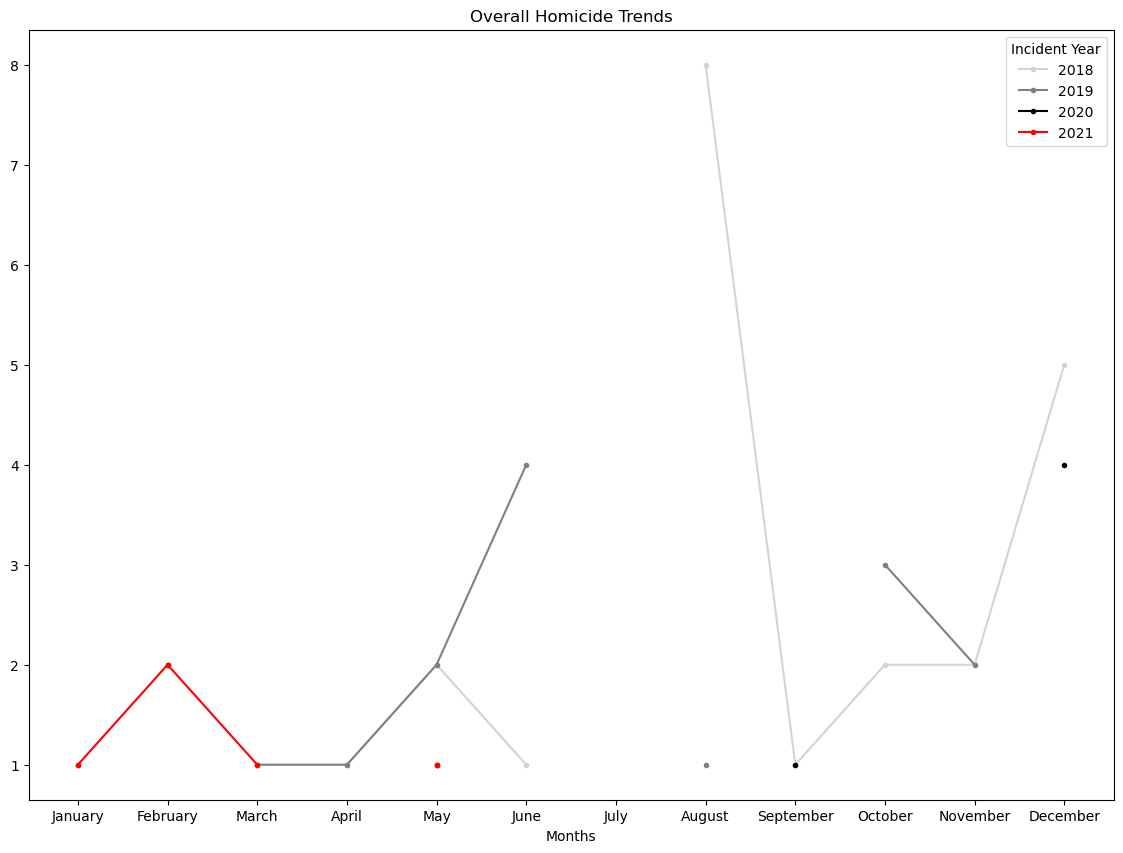

In [1562]:
# homicide trends

incident_graph(violentincidents, 'homicide ', 'Overall Homicide Trends')

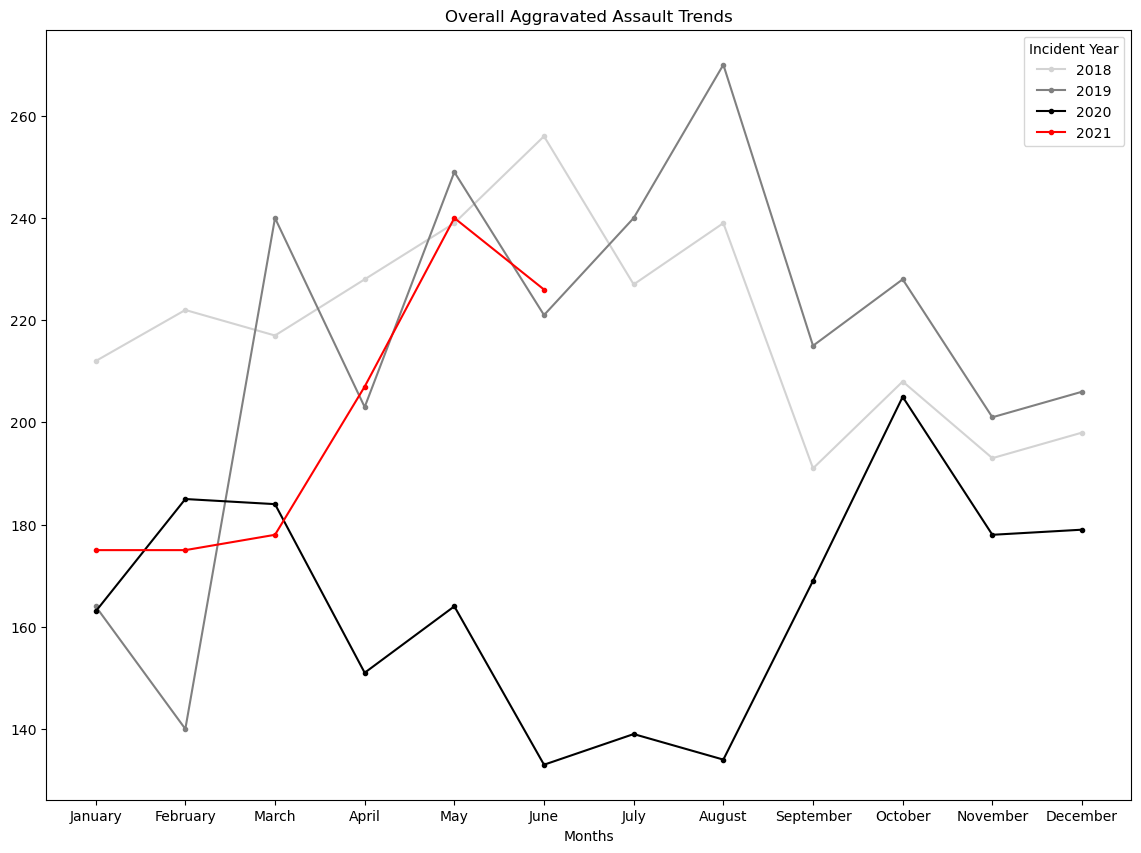

In [1563]:
# aggravated assault trends

incident_graph(violentincidents, 'aggravated assault', 'Overall Aggravated Assault Trends')

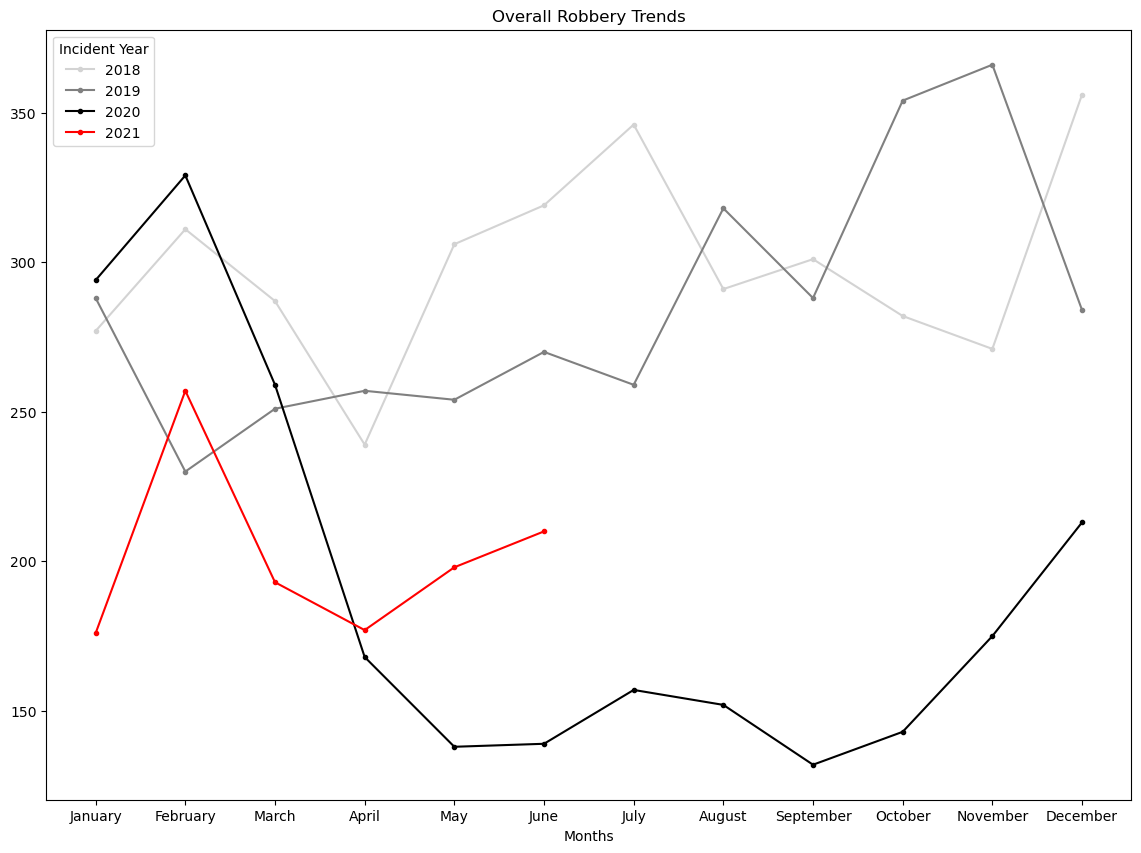

In [761]:
# robbery trends 

incident_graph(violentincidents, 'robbery', 'Overall Robbery Trends')

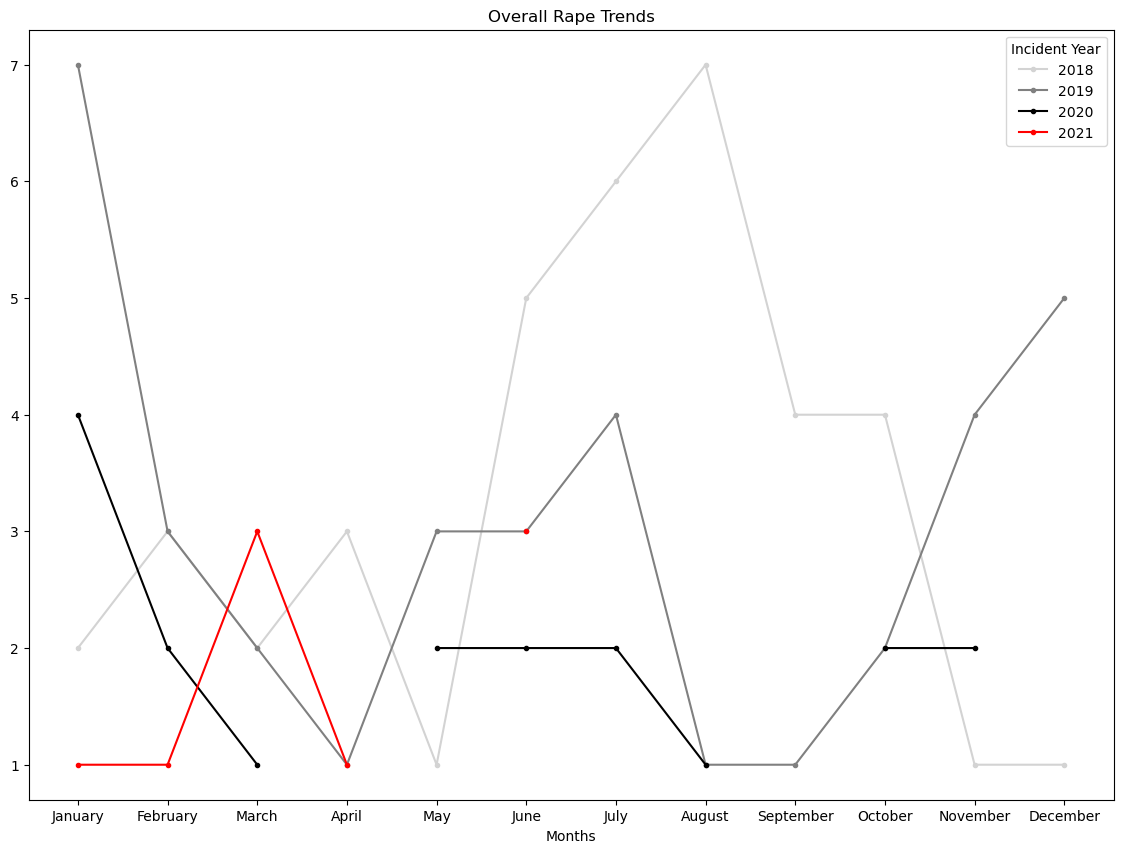

In [762]:
# rape trends

incident_graph(violentincidents, 'rape', 'Overall Rape Trends')

In [763]:
#pd.DataFrame(prepostviolent.groupby(['UCR_part_1', 'Incident Year','Months']).agg('size'))

# Property Incidents

In [764]:
# property crime visualization
# 175967 with UCR incident hierarchy

propertyincidents = filter_inrows_by_values(incident_report, 'UCR_part_1', ['burglary ', 'arson', 'larceny theft',
                                                                         'motor vehicle theft'])


In [765]:
property_incidents = pd.pivot_table(propertyincidents, index = 'Months', columns = 'Incident Year', values = 'UCR_part_1', aggfunc = 'size')
total_propertyincidents = property_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_propertyincidents

Incident Year,2018,2019,2020,2021
Months,,,,
January,5368.0,4429.0,5061.0,3108.0
February,4295.0,4109.0,4281.0,3255.0
March,4568.0,4317.0,3347.0,3331.0
April,4615.0,4207.0,2895.0,3423.0
May,4831.0,4568.0,2862.0,4395.0
June,4843.0,4661.0,2534.0,4263.0
July,5610.0,5292.0,2824.0,NaN
August,5549.0,5485.0,2760.0,NaN
September,4964.0,5125.0,2286.0,NaN


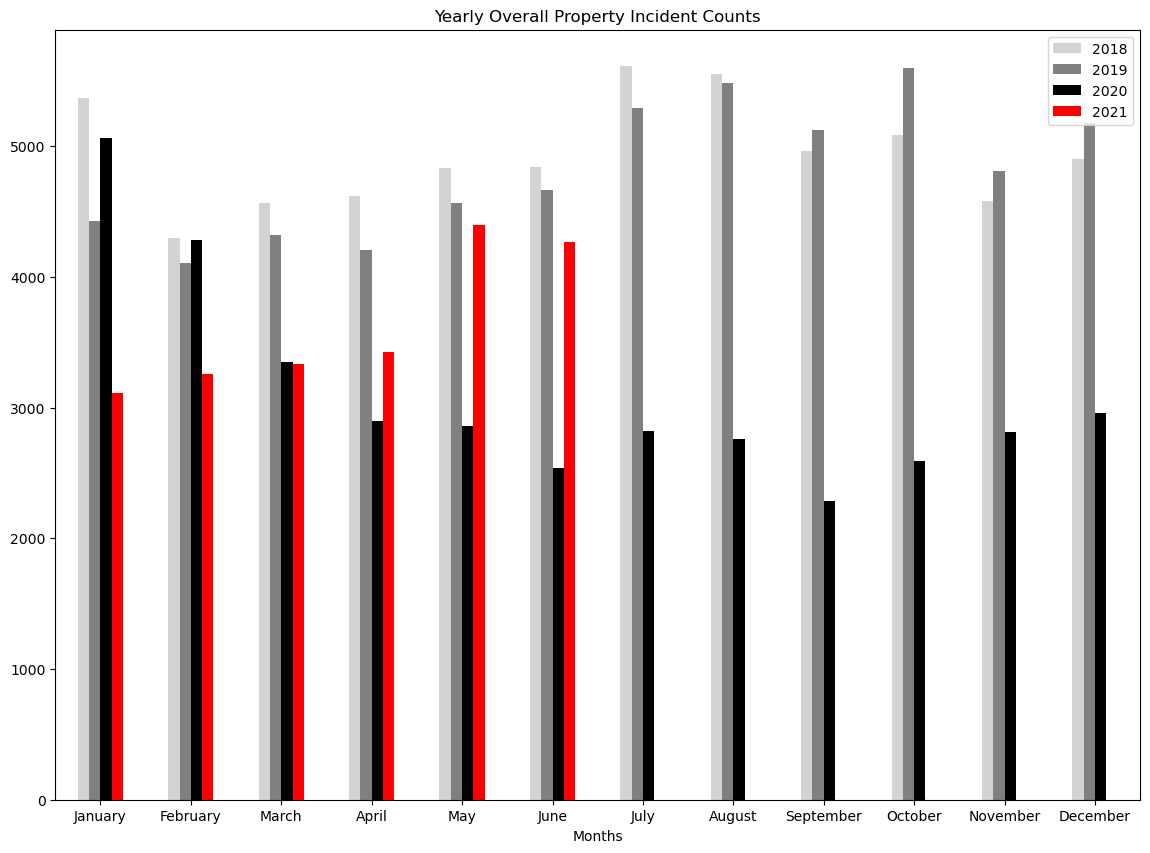

In [1102]:
total_propertyincidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Property Incident Counts')
plt.legend(loc = 'best');

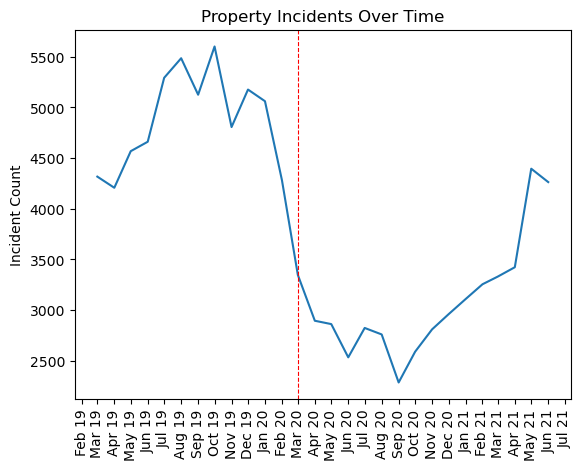

In [1099]:
total_graph(propertyincidents, 'Property Incidents Over Time')

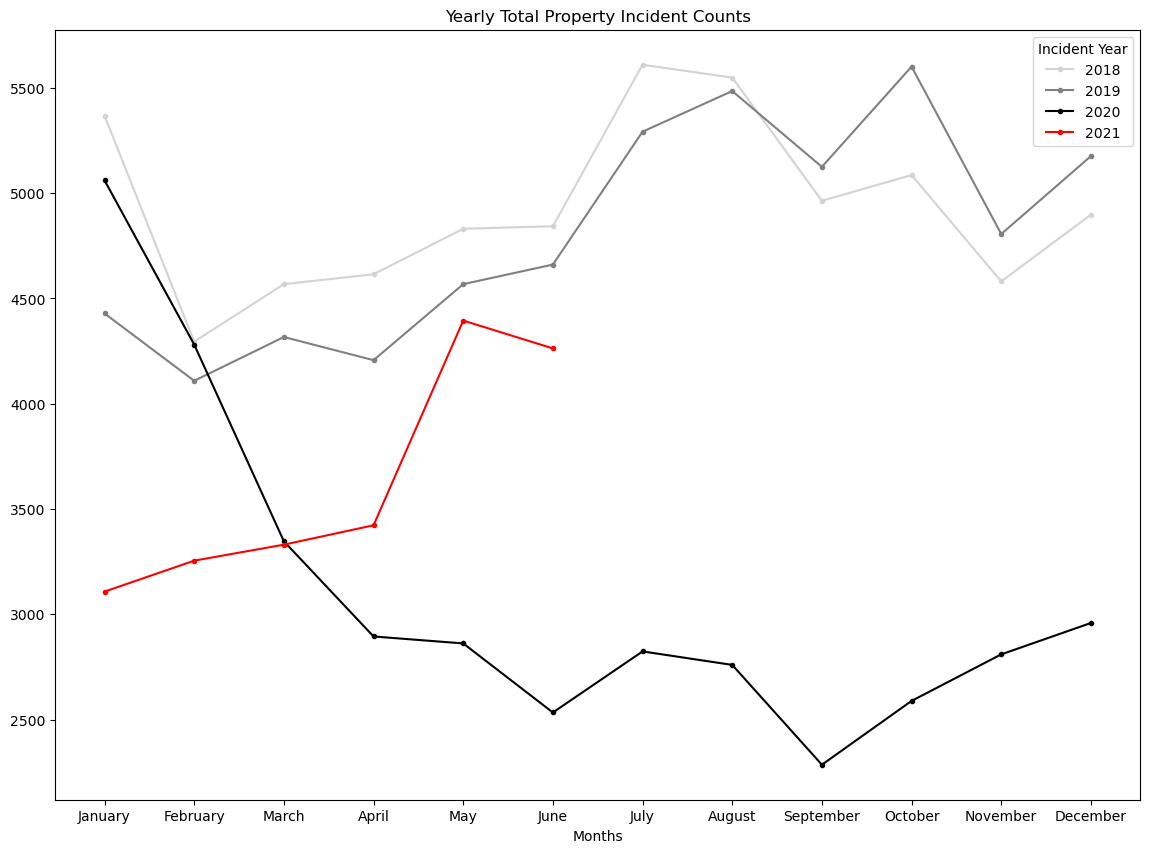

In [1101]:
propertyline = total_propertyincidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
propertyline.set_xticks(np.arange(0,12))
propertyline.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
propertyline.set_title('Yearly Total Property Incident Counts');

In [1036]:
incident_agg(propertyincidents)

Incident Year                    2018    2019    2020    2021
UCR_part_1          Months                                   
arson               January      24.0    24.0    23.0    32.0
                    February     25.0    18.0    21.0    34.0
                    March        28.0    19.0    29.0    36.0
                    April        34.0    22.0    36.0    37.0
                    May          20.0    24.0    30.0    27.0
                    June         30.0    17.0    29.0    36.0
                    July         22.0    22.0    27.0     NaN
                    August       35.0    30.0    41.0     NaN
                    September    18.0    32.0    22.0     NaN
                    October      39.0    33.0    22.0     NaN
                    November     43.0    34.0    19.0     NaN
                    December     24.0    20.0    29.0     NaN
burglary            January     602.0   514.0   573.0   783.0
                    February    531.0   460.0   493.0   775.0
                    March       583.0   521.0   508.0   681.0
                    April       581.0   486.0   720.0   650.0
                    May         630.0   530.0   836.0   673.0
                    June        562.0   421.0   590.0   649.0
                    July        627.0   535.0   652.0     NaN
                    August      698.0   522.0   596.0     NaN
                    September   585.0   454.0   527.0     NaN
                    October     542.0   489.0   568.0     NaN
                    November    480.0   489.0   546.0     NaN
                    December    511.0   503.0   702.0     NaN
larceny theft       January    4328.0  3478.0  3995.0  1698.0
                    February   3377.0  3235.0  3290.0  1833.0
                    March      3565.0  3367.0  2309.0  2033.0
                    April      3614.0  3262.0  1627.0  2169.0
                    May        3737.0  3573.0  1507.0  3037.0
                    June       3775.0  3770.0  1408.0  3001.0
                    July       4481.0  4284.0  1529.0     NaN
                    August     4378.0  4509.0  1643.0     NaN
                    September  3923.0  4161.0  1354.0     NaN
                    October    4013.0  4623.0  1509.0     NaN
                    November   3612.0  3794.0  1702.0     NaN
                    December   3909.0  4186.0  1666.0     NaN
motor vehicle theft January     414.0   413.0   470.0   595.0
                    February    362.0   396.0   477.0   613.0
                    March       392.0   410.0   501.0   581.0
                    April       386.0   437.0   512.0   567.0
                    May         444.0   441.0   489.0   658.0
                    June        476.0   453.0   507.0   577.0
                    July        480.0   451.0   616.0     NaN
                    August      438.0   424.0   480.0     NaN
                    September   438.0   478.0   383.0     NaN
                    October     492.0   456.0   490.0     NaN
                    November    446.0   489.0   543.0     NaN
                    December    454.0   467.0   562.0     NaN

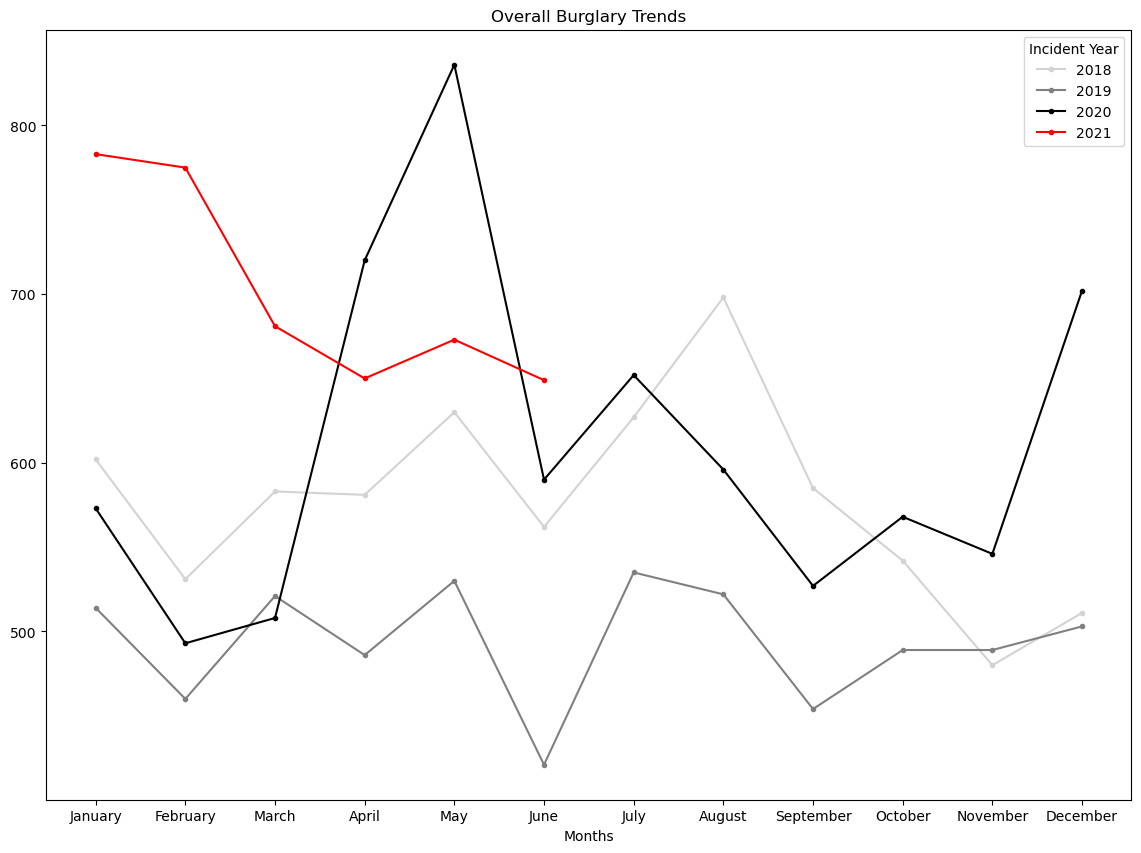

In [768]:
# burglary trends 

incident_graph(propertyincidents, 'burglary ', 'Overall Burglary Trends')

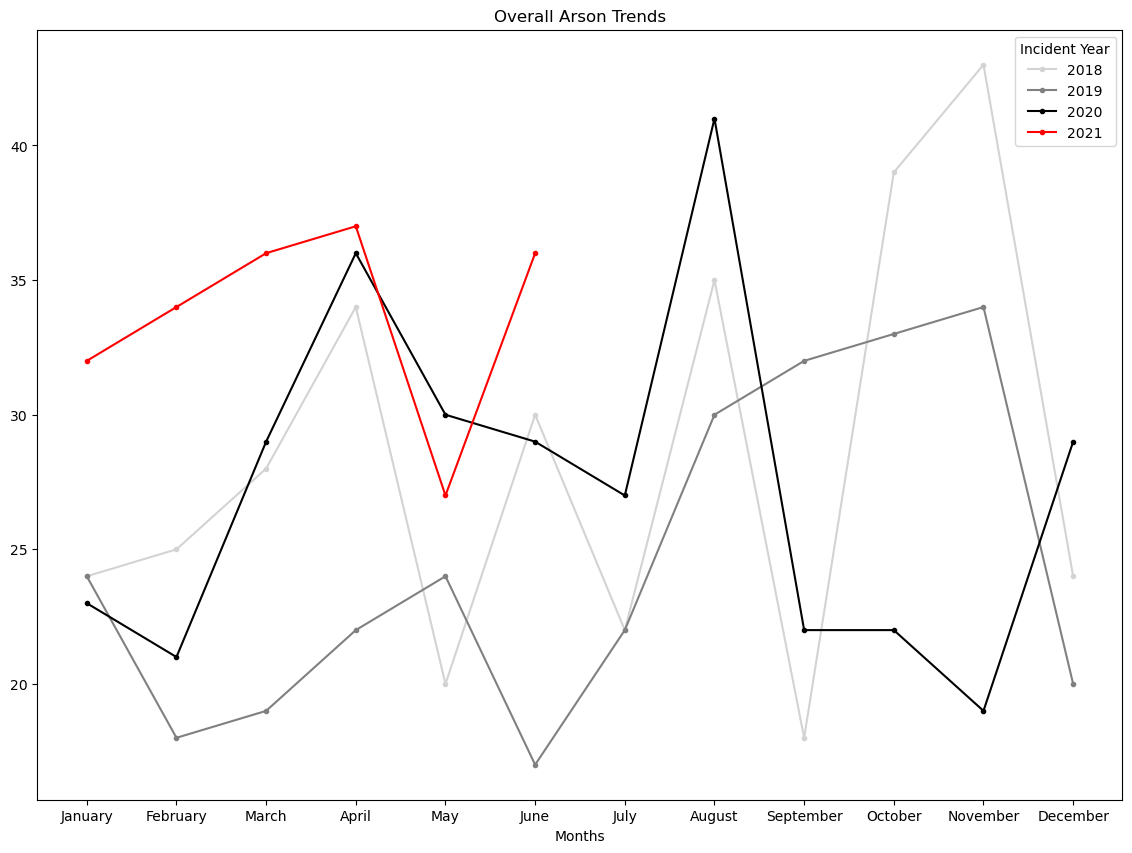

In [769]:
# arson trends 

incident_graph(propertyincidents, 'arson', 'Overall Arson Trends')

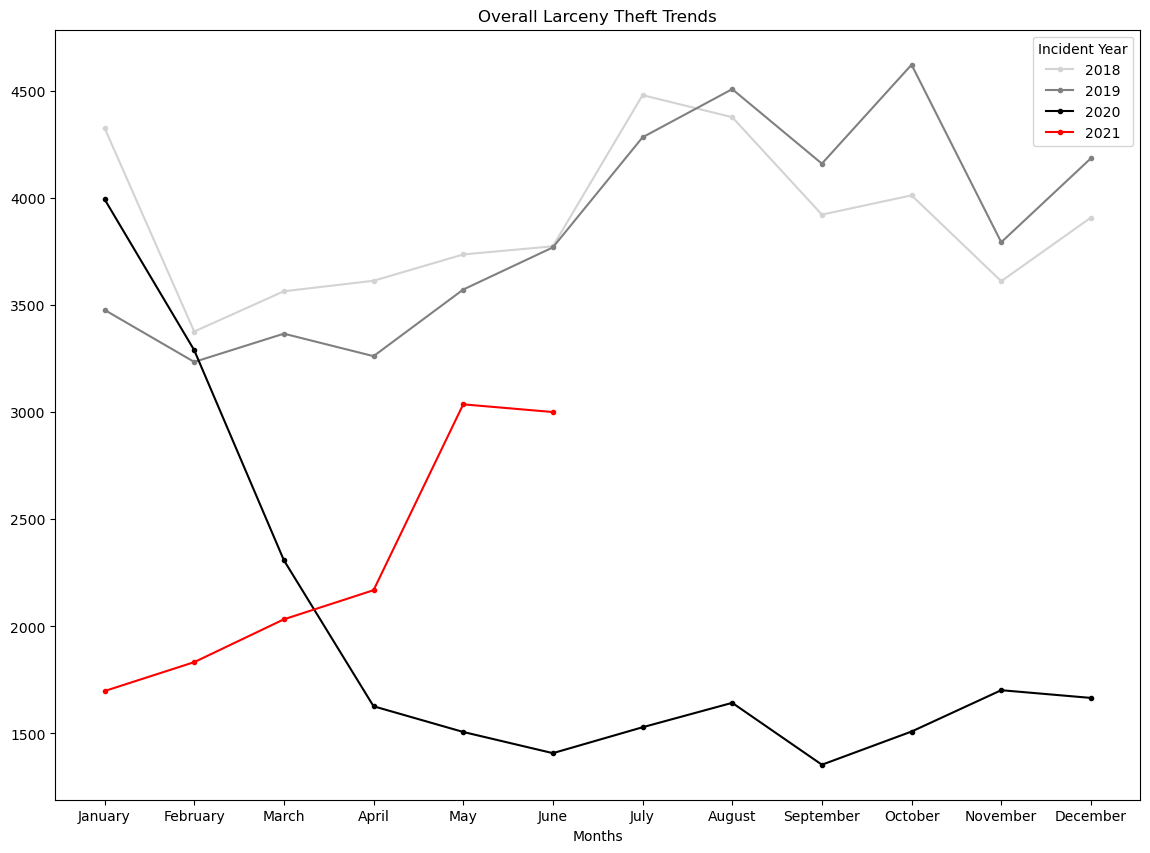

In [770]:
# larceny theft trends 

incident_graph(propertyincidents, 'larceny theft', 'Overall Larceny Theft Trends')

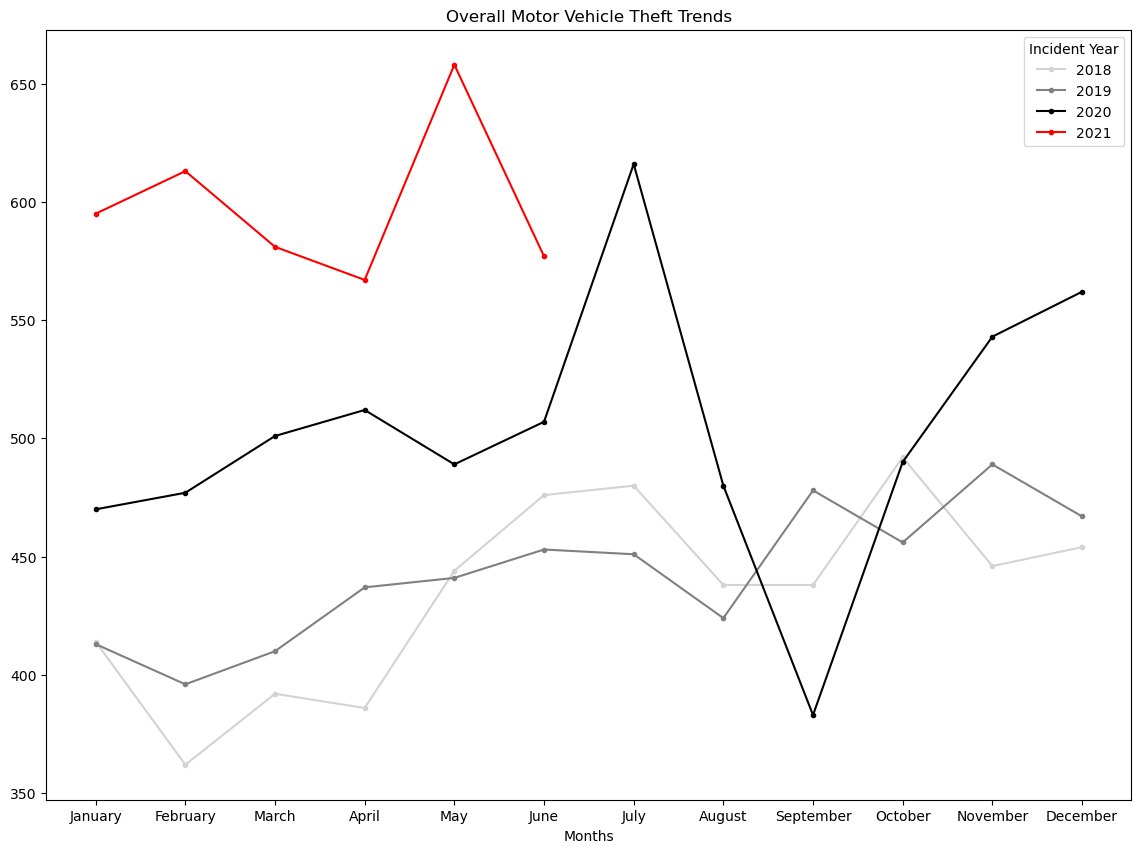

In [771]:
# motor vehicle theft trends 

incident_graph(propertyincidents, 'motor vehicle theft', 'Overall Motor Vehicle Theft Trends')

In [965]:
print(incident_report['Incident Date'].max())
print(incident_report['Incident Date'].min())

2021-06-30 00:00:00
2018-01-01 00:00:00


# Mapping

In [1237]:
# reading in geometric map

sfmap = gpd.read_file('Analysis Neighborhoods.geojson')

In [879]:
# not useful for violent incidents as they are rare 

def heat_map(df, title):
    map = sns.heatmap(df, linewidths = .5, center = total_incidents.loc['March', 2020])
    map.set_title(title)

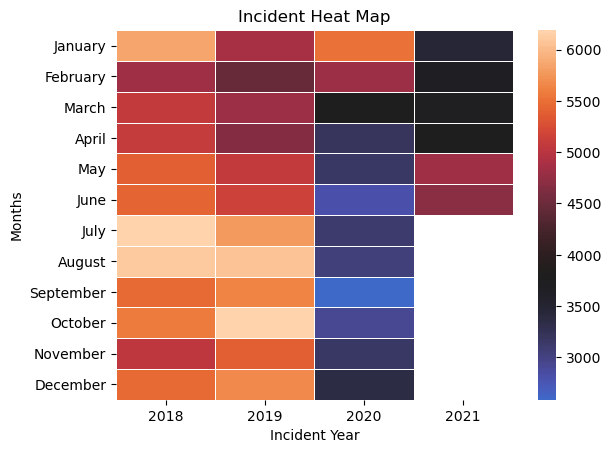

In [880]:
heat_map(total_incidents, 'Incident Heat Map')

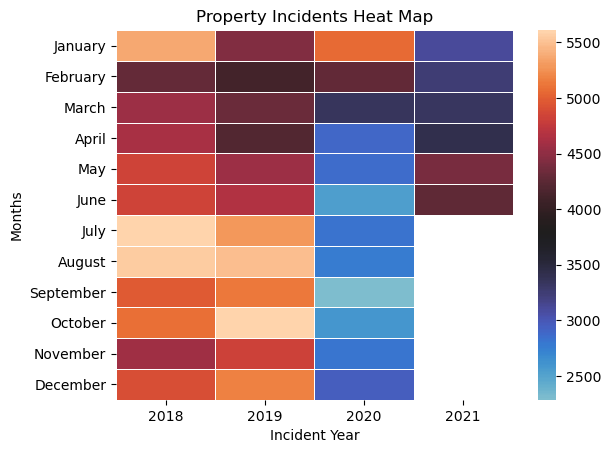

In [882]:
heat_map(total_propertyincidents, 'Property Incidents Heat Map')

In [1558]:
# this function will illustrate the TOTAL incidents over the ~3.5 years the data withholds 

def shape_heattool(df, title):
    df['count'] = 1
    n_data = df.groupby('Analysis Neighborhood').count()['count'].reset_index()
    n_data.sort_values('count', ascending = False)
    
    new_df = sfmap.set_index('nhood').join(n_data.set_index('Analysis Neighborhood'))
    new_df = new_df.reset_index().fillna(0)
    
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.axis('off')
    ax.set_title(title)
    
    color = 'Oranges'
    vmin, vmax = 0, 20000
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=12)

    new_df.plot('count', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8')
    
    for idx, row in new_df.iterrows():
        if (row['count'] >= 4000):
            plt.annotate(s=row['nhood'], 
                     xy=row.geometry.centroid.coords[0],
                     horizontalalignment='center',
                     fontsize='small', color='black', wrap= True)

C:\Users\simon\AppData\Local\Temp/ipykernel_7920/1921182000.py:27: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



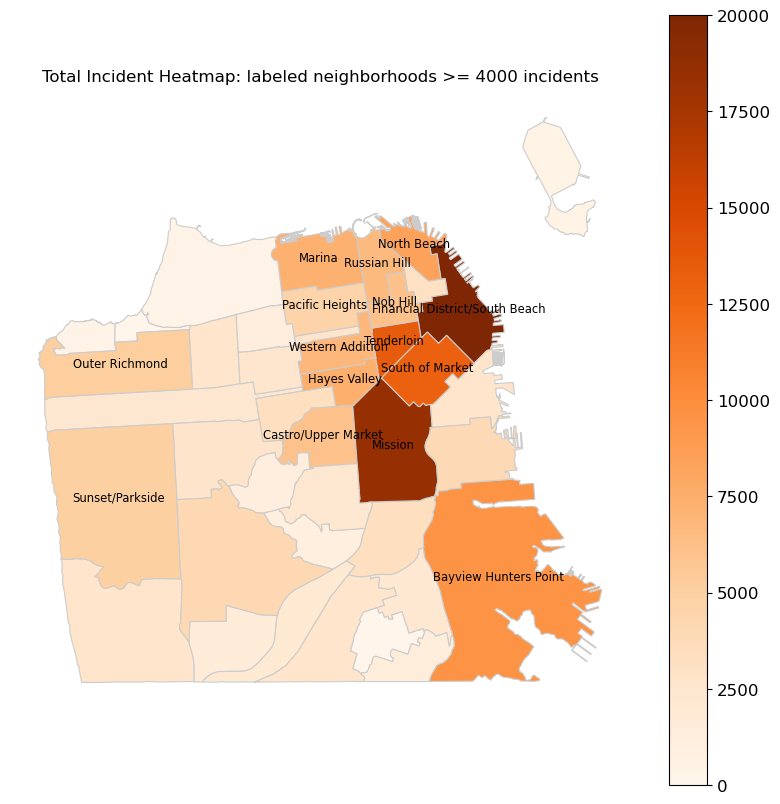

In [1555]:
shape_heattool(total_incidents1, 'Total Incident Heatmap: labeled neighborhoods >= 4000 incidents')

C:\Users\simon\AppData\Local\Temp/ipykernel_7920/1921182000.py:27: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



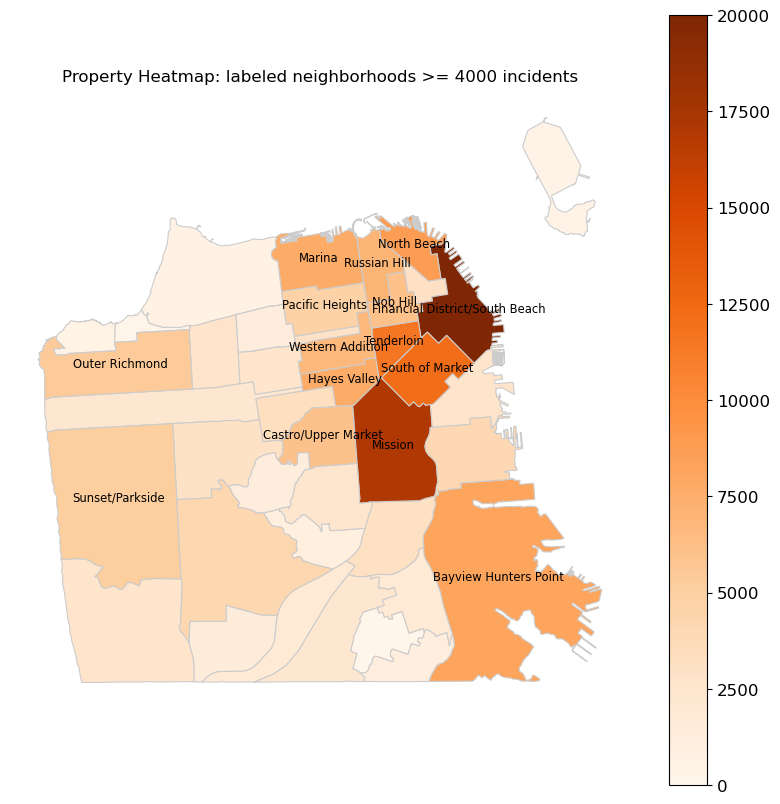

In [1556]:
shape_heattool(propertyincidents, 'Property Heatmap: labeled neighborhoods >= 4000 incidents')

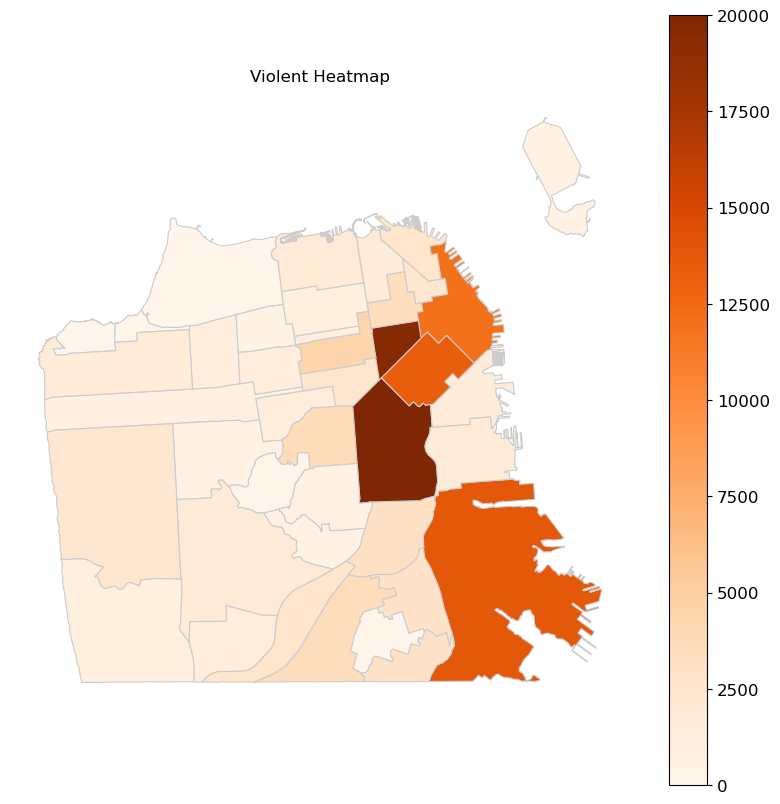

In [1557]:
shape_heattool(violentincidents, 'Violent Heatmap')

In [1502]:
# total category over four years mapper

def category_mapper(df, itype, title):
    fig, ax = plt.subplots(figsize = (10,10))
    sfmap.plot(color = 'lightgrey', ax = ax)
    df = df[df['UCR_part_1'] == itype]
    df.plot(column = 'UCR_part_1', ax = ax, alpha = .05)
    plt.title(title)

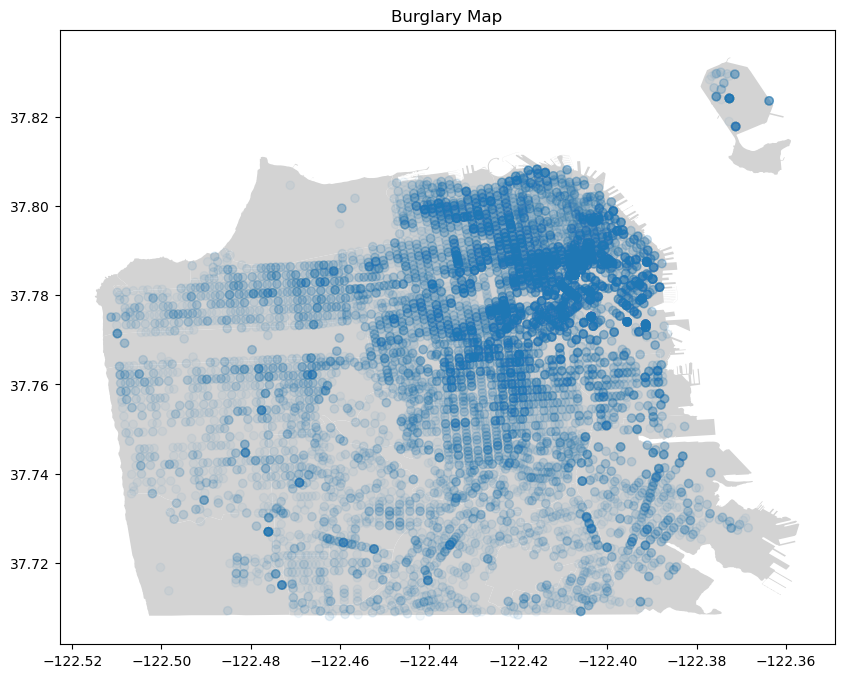

In [1503]:
category_mapper(propertyincidents, 'burglary ', 'Burglary Map')

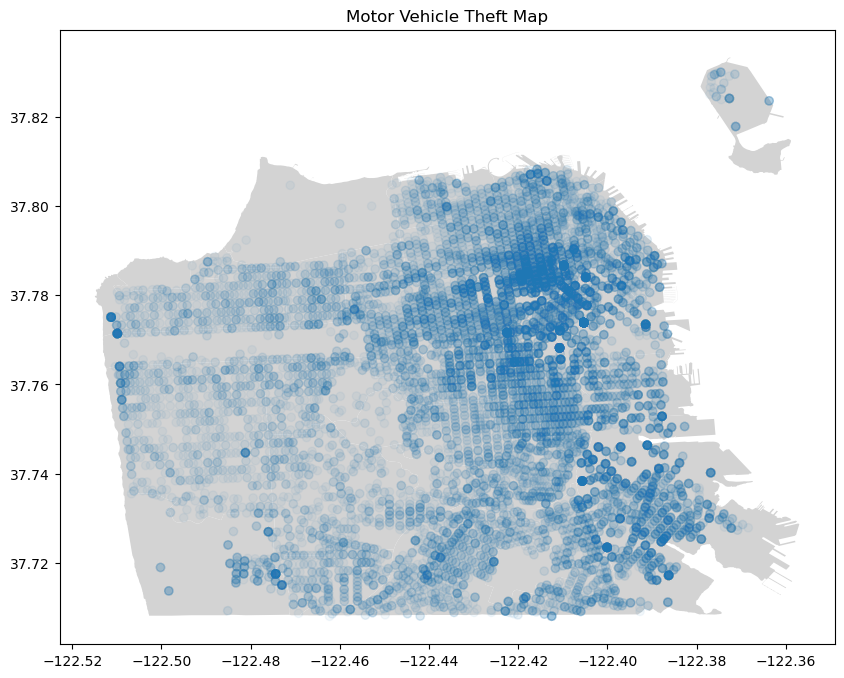

In [1061]:
category_mapper(propertyincidents, 'motor vehicle theft', 'Motor Vehicle Theft Map')

# Pre- and Post-Pandemic Analysis

In [1065]:
def pandemic_mapper(df):
    fig, ax = plt.subplots(1, figsize = (10,10))
    sfmap.plot(color = 'lightgrey', ax = ax)
    prepandemic = df[(df['Incident Date'] >= '2019-03-17') 
                          & (df['Incident Date'] <= '2020-03-16')]
    pandemic = df[(df['Incident Date'] >= '2020-03-17')]
    
    prepandemic.plot(ax = ax, alpha = .5)
    pandemic.plot(ax = ax, alpha = .5)

In [ ]:
def mapper():
    

<AxesSubplot:>

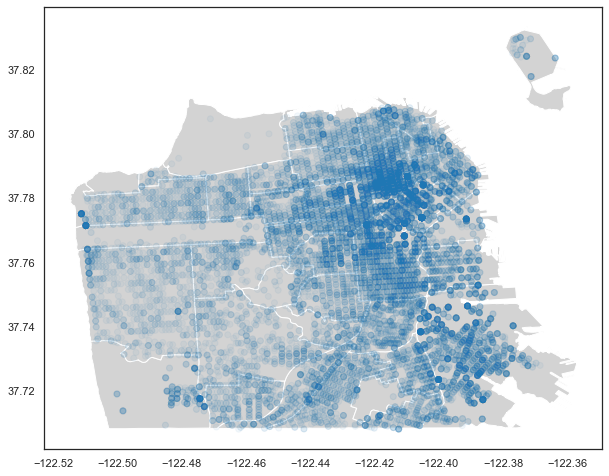

In [79]:
# motor vehicle thefts

fig, ax = plt.subplots(figsize = (10,10))
sfmap.plot(color = 'lightgrey', ax = ax)
mtv.plot(column = 'UCR_part_1', ax=ax, alpha = .05)